## Contrôle des feux de signalisation

Ce programme présente une implémentation d'un controller step-based décrit dans l'article "Guidelines for Action Space Definition in Reinforcement Learning-Based Traffic Signal Control Systems" de Maxime Treca, Julian Garbiso, Dominique Barth.

l'objet d'étude est une intersection composée de 4 routes qui arrivent de chaque direction Nord, Sud, Est, Ouest


<img src="files/figures/intersection.jpg" width="500px"/>

Un scénario dure 10 000 steps

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Vehicule:
    def __init__(self, approach):
        self.approach = approach
        self.waiting_time = 0
        
    def update_waiting_time(self):
        self.waiting_time += 1
        
    def get_waiting_time(self):
        return self.waiting_time

In [3]:
class IntersectionEnvironment:
    
    def __init__(self, d_min, d_max, n_step,tau, controller_type = 'step-based'):
        #durée min et max d'une phase
        self.d_min = d_min
        self.d_max = d_max
        
        self.n_step = n_step
        self.tau = tau
        
        #cycle Ψ
        self.signal_cycle = ['ψ1', 'ψT', 'ψ2', 'ψT'] 
        self.controller_type = controller_type
        
        #Durée initiale de chaque phase de ψ
        self.phase_duration = {
            'ψ1': self.d_min,
            'ψ2': self.d_min,
            'ψT': 5
        }
        
        #liste des véhicules sur les 4 routes Nord, Sud, Est, Ouest
        self.approaches ={
            'N' :[],
            'S' :[],
            'W' :[],
            'E':[]
        }
        
        #Indice et durée de la phase initiale
        self.current_phase_idx = 0
        self.current_phase_duration = self.phase_duration[self.signal_cycle[self.current_phase_idx]]
        self.time_since_last_phase = 0
        
        #Congestion associée à chaque phase
        self.congestion = {'ψ1': 0, 'ψ2': 0}
        
        #temps attente de chaque phase
        self.phase_waiting_time = {
            'ψ1': 0,
            'ψ2': 0
        }
        self.old_cumulated_waiting_time = 0

        
        #temps d'attente cumulé
        self.cumulated_waiting_time = 0
        
        #temps t actuelle
        self.time_elapsed = 0
        
        #nombre de départ pour chaque phase
        self.departure =  {
            'ψ1': 0,
            'ψ2': 0
        }
        
        
    def reset(self):
        self.phase_duration = {
            'ψ1': self.d_min,
            'ψ2': self.d_min,
            'ψT': 5
        }
        self.approaches ={
            'N' :[],
            'S' :[],
            'W' :[],
            'E':[]
        }
        self.current_phase_idx = 0
        self.current_phase_duration = self.phase_duration[self.signal_cycle[self.current_phase_idx]]
        self.time_since_last_phase = 0
        self.congestion = {'ψ1': 0, 'ψ2': 0}
        
        self.time_elapsed = 0
        self.departure =  {
            'ψ1': 0,
            'ψ2': 0
        }
        self.cumulated_waiting_time = 0
        self.old_cumulated_waiting_time = 0
        self.phase_waiting_time = {
            'ψ1': 0,
            'ψ2': 0
        }
        return ('ψ1', self.phase_duration['ψ1'], self.congestion['ψ1'], self.congestion['ψ2'])
    
    def step(self, action):
        #print( " t =  :", self.time_elapsed," phase", self.signal_cycle[self.current_phase_idx] )
        terminal = False
        reward = 0
        self.time_elapsed+=1
        self.time_since_last_phase += 1
        
        
        # Generate traffic demand
        self.generate_trafic(self.tau)
        
        # Updating traffic
        self.update_trafic()
        
        #update waiting time of vehicules
        self.update_waiting_time(self.current_phase_idx)
        
        #cumulated waiting time at time t
        self.cumulated_waiting_time = self.get_cumulated_waiting_time()

        #Transition phase
        if self.time_since_last_phase == self.current_phase_duration and self.signal_cycle[self.current_phase_idx] == 'ψT' :
            self.time_since_last_phase = 0
            self.switch_phase()
         
        #Decision point
        elif self.time_since_last_phase == self.current_phase_duration and self.signal_cycle[self.current_phase_idx] != 'ψT' :
            
            #cumulated waiting time at the last decision point
            self.old_cumulated_waiting_time = self.cumulated_waiting_time
            
            if action == 0: # Extend the current phase
                if self.current_phase_duration == self.d_max:
                    self.time_since_last_phase = 0
                    self.switch_phase()
                elif self.current_phase_duration + self.n_step <= self.d_max:
                    #print( "phase extended by ", self.n_step)
                    self.current_phase_duration += self.n_step
                elif self.current_phase_duration + self.n_step > self.d_max:
                    self.time_since_last_phase = 0
                    self.switch_phase()
                    
            else: # Switch to the next phase
                self.time_since_last_phase = 0
                self.switch_phase()
        
        #congestion at time t
        self.congestion = self.update_congestion() 
        
        #difference between the cumulated waiting time at the last decision point and the cumulated waiting time at time t
        reward = self.old_cumulated_waiting_time - self.cumulated_waiting_time
        
        state = (self.signal_cycle[self.current_phase_idx],self.time_since_last_phase, self.congestion['ψ1'], self.congestion['ψ2'])
        
        #a scenario lasts for 10,000 steps
        if self.time_elapsed == 10000: 
            terminal = True
        return state,reward,terminal
    
    def switch_phase(self):
        #switch to the next phase of the cycle Ψ 
        self.current_phase_idx = (self.current_phase_idx + 1) % len(self.signal_cycle) 
        self.current_phase_duration = self.phase_duration[self.signal_cycle[self.current_phase_idx]]
    
    def generate_trafic(self,tau):
        # Generate traffic demand using two Poisson processes
        λ = (0.5 - tau)
        poisson_1 = np.random.poisson(λ/4, 4)
        poisson_2 = np.random.poisson(tau/2, 2)
        #uniform arrivals
        if poisson_1[0]:
            self.approaches['N'].append(Vehicule('N'))
        if poisson_1[1]:
            self.approaches['S'].append(Vehicule('S'))
        if poisson_1[2]:
            self.approaches['W'].append(Vehicule('W'))
        if poisson_1[3]:
            self.approaches['E'].append(Vehicule('E'))
        
        #arrivals north and south
        if poisson_2[0]:
            self.approaches['N'].append(Vehicule('N'))
        if poisson_2[1]:
            self.approaches['S'].append(Vehicule('S'))
        
    def update_trafic(self):
        depart = 1
        #phase ψ1
        for i in range(depart):
            if self.current_phase_idx == 0 :
                
                if len(self.approaches['N']) > 0:
                    self.phase_waiting_time['ψ1'] += self.approaches['N'][0].get_waiting_time()
                    #first vehicule of the approach leave when it's green light
                    self.approaches['N'].pop(0) 
                    self.departure['ψ1'] +=1
                if len(self.approaches['S']) > 0:
                    self.phase_waiting_time['ψ1'] += self.approaches['S'][0].get_waiting_time()
                    self.approaches['S'].pop(0) 
                    self.departure['ψ1'] +=1

            #phase ψ2
            elif self.current_phase_idx == 2:
                
                if len(self.approaches['W']) > 0:
                    self.phase_waiting_time['ψ2'] += self.approaches['W'][0].get_waiting_time()
                    self.approaches['W'].pop(0)
                    self.departure['ψ2'] +=1
                if len(self.approaches['E']) > 0:
                    self.phase_waiting_time['ψ2'] += self.approaches['E'][0].get_waiting_time()
                    self.approaches['E'].pop(0)
                    self.departure['ψ2'] +=1
                  
    def update_congestion(self):
        self.congestion['ψ1'] = (len(self.approaches['N']) + len(self.approaches['S']))%3
        self.congestion['ψ2'] = (len(self.approaches['W']) + len(self.approaches['E']))%3
        return self.congestion
    
    def update_waiting_time(self,current_phase):
        if current_phase == 0: #if current phase is ψ1
            #the vehicules on the approach of ψ2 wait
            for v in self.approaches['W']:
                v.update_waiting_time()
            for w in self.approaches['E']:
                w.update_waiting_time()
        if current_phase == 2:#if current phase is ψ2
            #the vehicules on the approach of ψ1 wait
            for v in self.approaches['N']:
                v.update_waiting_time()
            for w in self.approaches['S']:
                w.update_waiting_time()
    
    def get_cumulated_waiting_time(self):
        #total waiting time of vehicules in each approaches
        total = 0
        for v in self.approaches['N']:
                total += v.get_waiting_time()
        for w in self.approaches['S']:
                total += w.get_waiting_time()
        for v in self.approaches['W']:
                total += v.get_waiting_time()
        for w in self.approaches['E']:
                total += w.get_waiting_time()
        return total
        
        

In [4]:
class Agent:
    def __init__(self, tauxApprentissage, gamma, epsilon):
        self.tauxApprentissage = tauxApprentissage
        self.action_space = [0, 1]  # 0 - phase extension of n steps, 1 - switch to next phase
        self.gamma = gamma
        self.epsilon = epsilon
        self.tableauQ = {}

    def choisirAction(self, etat):
        if np.random.uniform() < self.epsilon:
            # Exploration
            return np.random.choice(self.action_space)
        else:
            # Exploitation
            if etat in self.tableauQ:
                return np.argmax(self.tableauQ[etat])
            else:
                return np.random.choice(self.action_space)

    def majTableauQ(self, etat, action, recompense, prochainEtat):
        if etat not in self.tableauQ:
            self.tableauQ[etat] = np.zeros(42)

        if prochainEtat not in self.tableauQ:
            self.tableauQ[prochainEtat] = np.zeros(42)

        ancienneValeur = self.tableauQ[etat][action]
        prochainMax = np.max(self.tableauQ[prochainEtat])
        nouvelleValeur = (1 - self.tauxApprentissage) * ancienneValeur + self.tauxApprentissage * (recompense + self.gamma * prochainMax)
        self.tableauQ[etat][action] = nouvelleValeur


In [5]:
def simulation(nbiter,n_step,d_min,d_max, tauxApprentissage,gamma,epsilon,tau):
    print("********Simulation pour n_step =", n_step, "********")
    list_log = []
    #environnement
    intersection = IntersectionEnvironment(d_min,d_max,n_step,tau,controller_type = 'step-based' )

    #agent
    agent = Agent(tauxApprentissage, gamma ,epsilon)

    for ne in range(nbiter):
        wait = 0
        state = intersection.reset()
        terminal = False
        print("iteration ", ne+1)

        while not terminal:
            #print("nb de voiture sur l'approche Nord",intersection.approaches["N"])
            action = agent.choisirAction(state)
            next_state,reward, terminal = intersection.step(action)

            if state[0] != 'ψT' or state[0] != 'ψT': #on vérifie que l'on est pas dans un état de transition
                agent.majTableauQ(state,action,reward,next_state)
            state = next_state

        print("/// RESULTATS ///")

        moyenne_phase1 = intersection.phase_waiting_time['ψ1']/intersection.departure['ψ1']
        moyenne_phase2 = intersection.phase_waiting_time['ψ2']/intersection.departure['ψ2']
        print("Temps d'attente moyen phase 1 :", moyenne_phase1)
        print("Temps d'attente moyen phase 2 :", moyenne_phase2)
        print("Temps d'attente moyen :", (moyenne_phase1+moyenne_phase2)/2)
        list_log.append((moyenne_phase1+moyenne_phase2)/2)
    return list_log



In [6]:
simul5 = []
simul15 = []
simul5 = simulation(nbiter=30,n_step =5,d_min=5,d_max=45, tauxApprentissage=0.01,gamma=0.05,epsilon=0.05, tau=0.1)
simul15 = simulation(nbiter=30,n_step =15,d_min=5,d_max=45, tauxApprentissage=0.01,gamma=0.05,epsilon=0.05,tau=0.1)

********Simulation pour n_step = 5 ********
iteration  1
/// RESULTATS ///
Temps d'attente moyen phase 1 : 12.636331569664902
Temps d'attente moyen phase 2 : 12.148936170212766
Temps d'attente moyen : 12.392633869938834
iteration  2
/// RESULTATS ///
Temps d'attente moyen phase 1 : 4.3116018226428325
Temps d'attente moyen phase 2 : 7.115926892950392
Temps d'attente moyen : 5.713764357796612
iteration  3
/// RESULTATS ///
Temps d'attente moyen phase 1 : 3.293745607870696
Temps d'attente moyen phase 2 : 4.225892381459777
Temps d'attente moyen : 3.7598189946652365
iteration  4
/// RESULTATS ///
Temps d'attente moyen phase 1 : 2.118184896715205
Temps d'attente moyen phase 2 : 4.234949387320192
Temps d'attente moyen : 3.1765671420176984
iteration  5
/// RESULTATS ///
Temps d'attente moyen phase 1 : 1.9257340241796201
Temps d'attente moyen phase 2 : 4.126544735541275
Temps d'attente moyen : 3.0261393798604477
iteration  6
/// RESULTATS ///
Temps d'attente moyen phase 1 : 2.028944581715496
Te

/// RESULTATS ///
Temps d'attente moyen phase 1 : 2.3708059494984433
Temps d'attente moyen phase 2 : 3.3175026680896478
Temps d'attente moyen : 2.8441543087940455
iteration  19
/// RESULTATS ///
Temps d'attente moyen phase 1 : 2.7274281805745555
Temps d'attente moyen phase 2 : 3.3556507766470274
Temps d'attente moyen : 3.041539478610791
iteration  20
/// RESULTATS ///
Temps d'attente moyen phase 1 : 2.3252236135957065
Temps d'attente moyen phase 2 : 3.0058760683760686
Temps d'attente moyen : 2.6655498409858875
iteration  21
/// RESULTATS ///
Temps d'attente moyen phase 1 : 2.3263083948015453
Temps d'attente moyen phase 2 : 3.136529442417926
Temps d'attente moyen : 2.7314189186097355
iteration  22
/// RESULTATS ///
Temps d'attente moyen phase 1 : 2.247581512002866
Temps d'attente moyen phase 2 : 3.3335084033613445
Temps d'attente moyen : 2.7905449576821053
iteration  23
/// RESULTATS ///
Temps d'attente moyen phase 1 : 2.747321119944694
Temps d'attente moyen phase 2 : 3.173621844410098


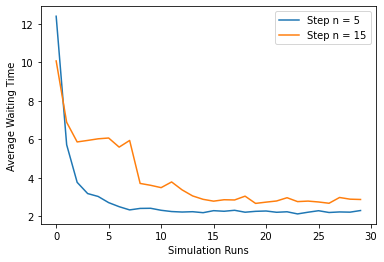

In [7]:
plt.plot(simul5,  label = 'Step n = 5')
plt.plot(simul15,  label = 'Step n = 15')
plt.xlabel('Simulation Runs')
plt.ylabel('Average Waiting Time')
plt.legend()